In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import pickle
import plotly.express as px
import plotly.graph_objs as go

In [3]:
pd.set_option('display.max_columns', None) #para poder ver todas las columnas

In [49]:
df = pd.read_csv('../data/rawcsv/Bigg.csv', sep=";", encoding= 'unicode_escape')

df

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430,Gloomhaven,2017.0,1.0,4.0,120.0,14.0,42055,"8,79",1,"3,86",68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936,Pandemic Legacy: Season 1,2015.0,2.0,4.0,60.0,13.0,41643,"8,61",2,"2,84",65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517,Brass: Birmingham,2018.0,2.0,4.0,120.0,14.0,19217,"8,66",3,"3,91",28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791,Terraforming Mars,2016.0,1.0,5.0,120.0,12.0,64864,"8,43",4,"3,24",87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078,Twilight Imperium: Fourth Edition,2017.0,3.0,6.0,480.0,14.0,13468,"8,70",5,"4,22",16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20339,16398,War,0.0,2.0,2.0,30.0,4.0,1340,"2,28",20340,"1,00",427,NaN,Children's Games
20340,7316,Bingo,1530.0,2.0,99.0,60.0,5.0,2154,"2,85",20341,"1,05",1533,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20341,5048,Candy Land,1949.0,2.0,4.0,30.0,3.0,4006,"3,18",20342,"1,08",5788,Roll / Spin and Move,Children's Games
20342,5432,Chutes and Ladders,-200.0,2.0,6.0,30.0,3.0,3783,"2,86",20343,"1,02",4400,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20344 entries, 0 to 20343
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20328 non-null  object 
 1   Name                20344 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  float64
 4   Max Players         20343 non-null  float64
 5   Play Time           20343 non-null  float64
 6   Min Age             20343 non-null  float64
 7   Users Rated         20343 non-null  object 
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  object 
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  object 
 12  Mechanics           18745 non-null  object 
 13  Domains             10183 non-null  object 
dtypes: float64(5), object(9)
memory usage: 2.2+ MB


In [50]:
df = df[df['Name'] != "2014"] #3 NaN
df = df[df['Name'] != "\91"]
df = df[df['Name'] != 'Hus']

In [51]:
df["Owned Users"].replace(({np.nan: 0}), inplace=True)

In [52]:
df["Domains"].replace(({np.nan: "Unknown"}), inplace=True)
df["Mechanics"].replace(({np.nan: "Unknown"}), inplace=True)

In [53]:
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T
        
data_report(df)

COL_N,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
DATA_TYPE,object,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object
MISSINGS (%),0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,20326,19972,188,11,54,116,21,2973,622,20341,379,3998,7381,40
CARDIN (%),99.93,98.19,0.92,0.05,0.27,0.57,0.1,14.62,3.06,100.0,1.86,19.65,36.29,0.2


## Feature Engineering 1

In [54]:
df['Year Published'] = df['Year Published'].astype(int)
df['Min Players'] = df['Min Players'].astype(int)
df['Max Players'] = df['Max Players'].astype(int)
df['Play Time'] = df['Play Time'].astype(int)
df['Min Age'] = df['Min Age'].astype(int)

In [55]:
df['Users Rated'] = df['Users Rated'].str.replace(',','.')
df['Users Rated'] = df['Users Rated'].astype(float)
df['Rating Average'] = df['Rating Average'].str.replace(',','.')
df['Rating Average'] = df['Rating Average'].astype(float)
df['BGG Rank'] = df['BGG Rank'].str.replace(',','.')
df['BGG Rank'] = df['BGG Rank'].astype(float)
df['Complexity Average'] = df['Complexity Average'].str.replace(',','.')
df['Complexity Average'] = df['Complexity Average'].astype(float)

In [56]:
df['Owned Users'] = pd.to_numeric(df['Owned Users'], errors='coerce')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20341 entries, 0 to 20343
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20326 non-null  object 
 1   Name                20341 non-null  object 
 2   Year Published      20341 non-null  int32  
 3   Min Players         20341 non-null  int32  
 4   Max Players         20341 non-null  int32  
 5   Play Time           20341 non-null  int32  
 6   Min Age             20341 non-null  int32  
 7   Users Rated         20341 non-null  float64
 8   Rating Average      20341 non-null  float64
 9   BGG Rank            20341 non-null  float64
 10  Complexity Average  20341 non-null  float64
 11  Owned Users         20341 non-null  int64  
 12  Mechanics           18744 non-null  object 
 13  Domains             10183 non-null  object 
dtypes: float64(4), int32(5), int64(1), object(4)
memory usage: 1.9+ MB


In [57]:
df["Owned Users"].replace(({np.nan: 0}), inplace=True)

## Visualizaciones

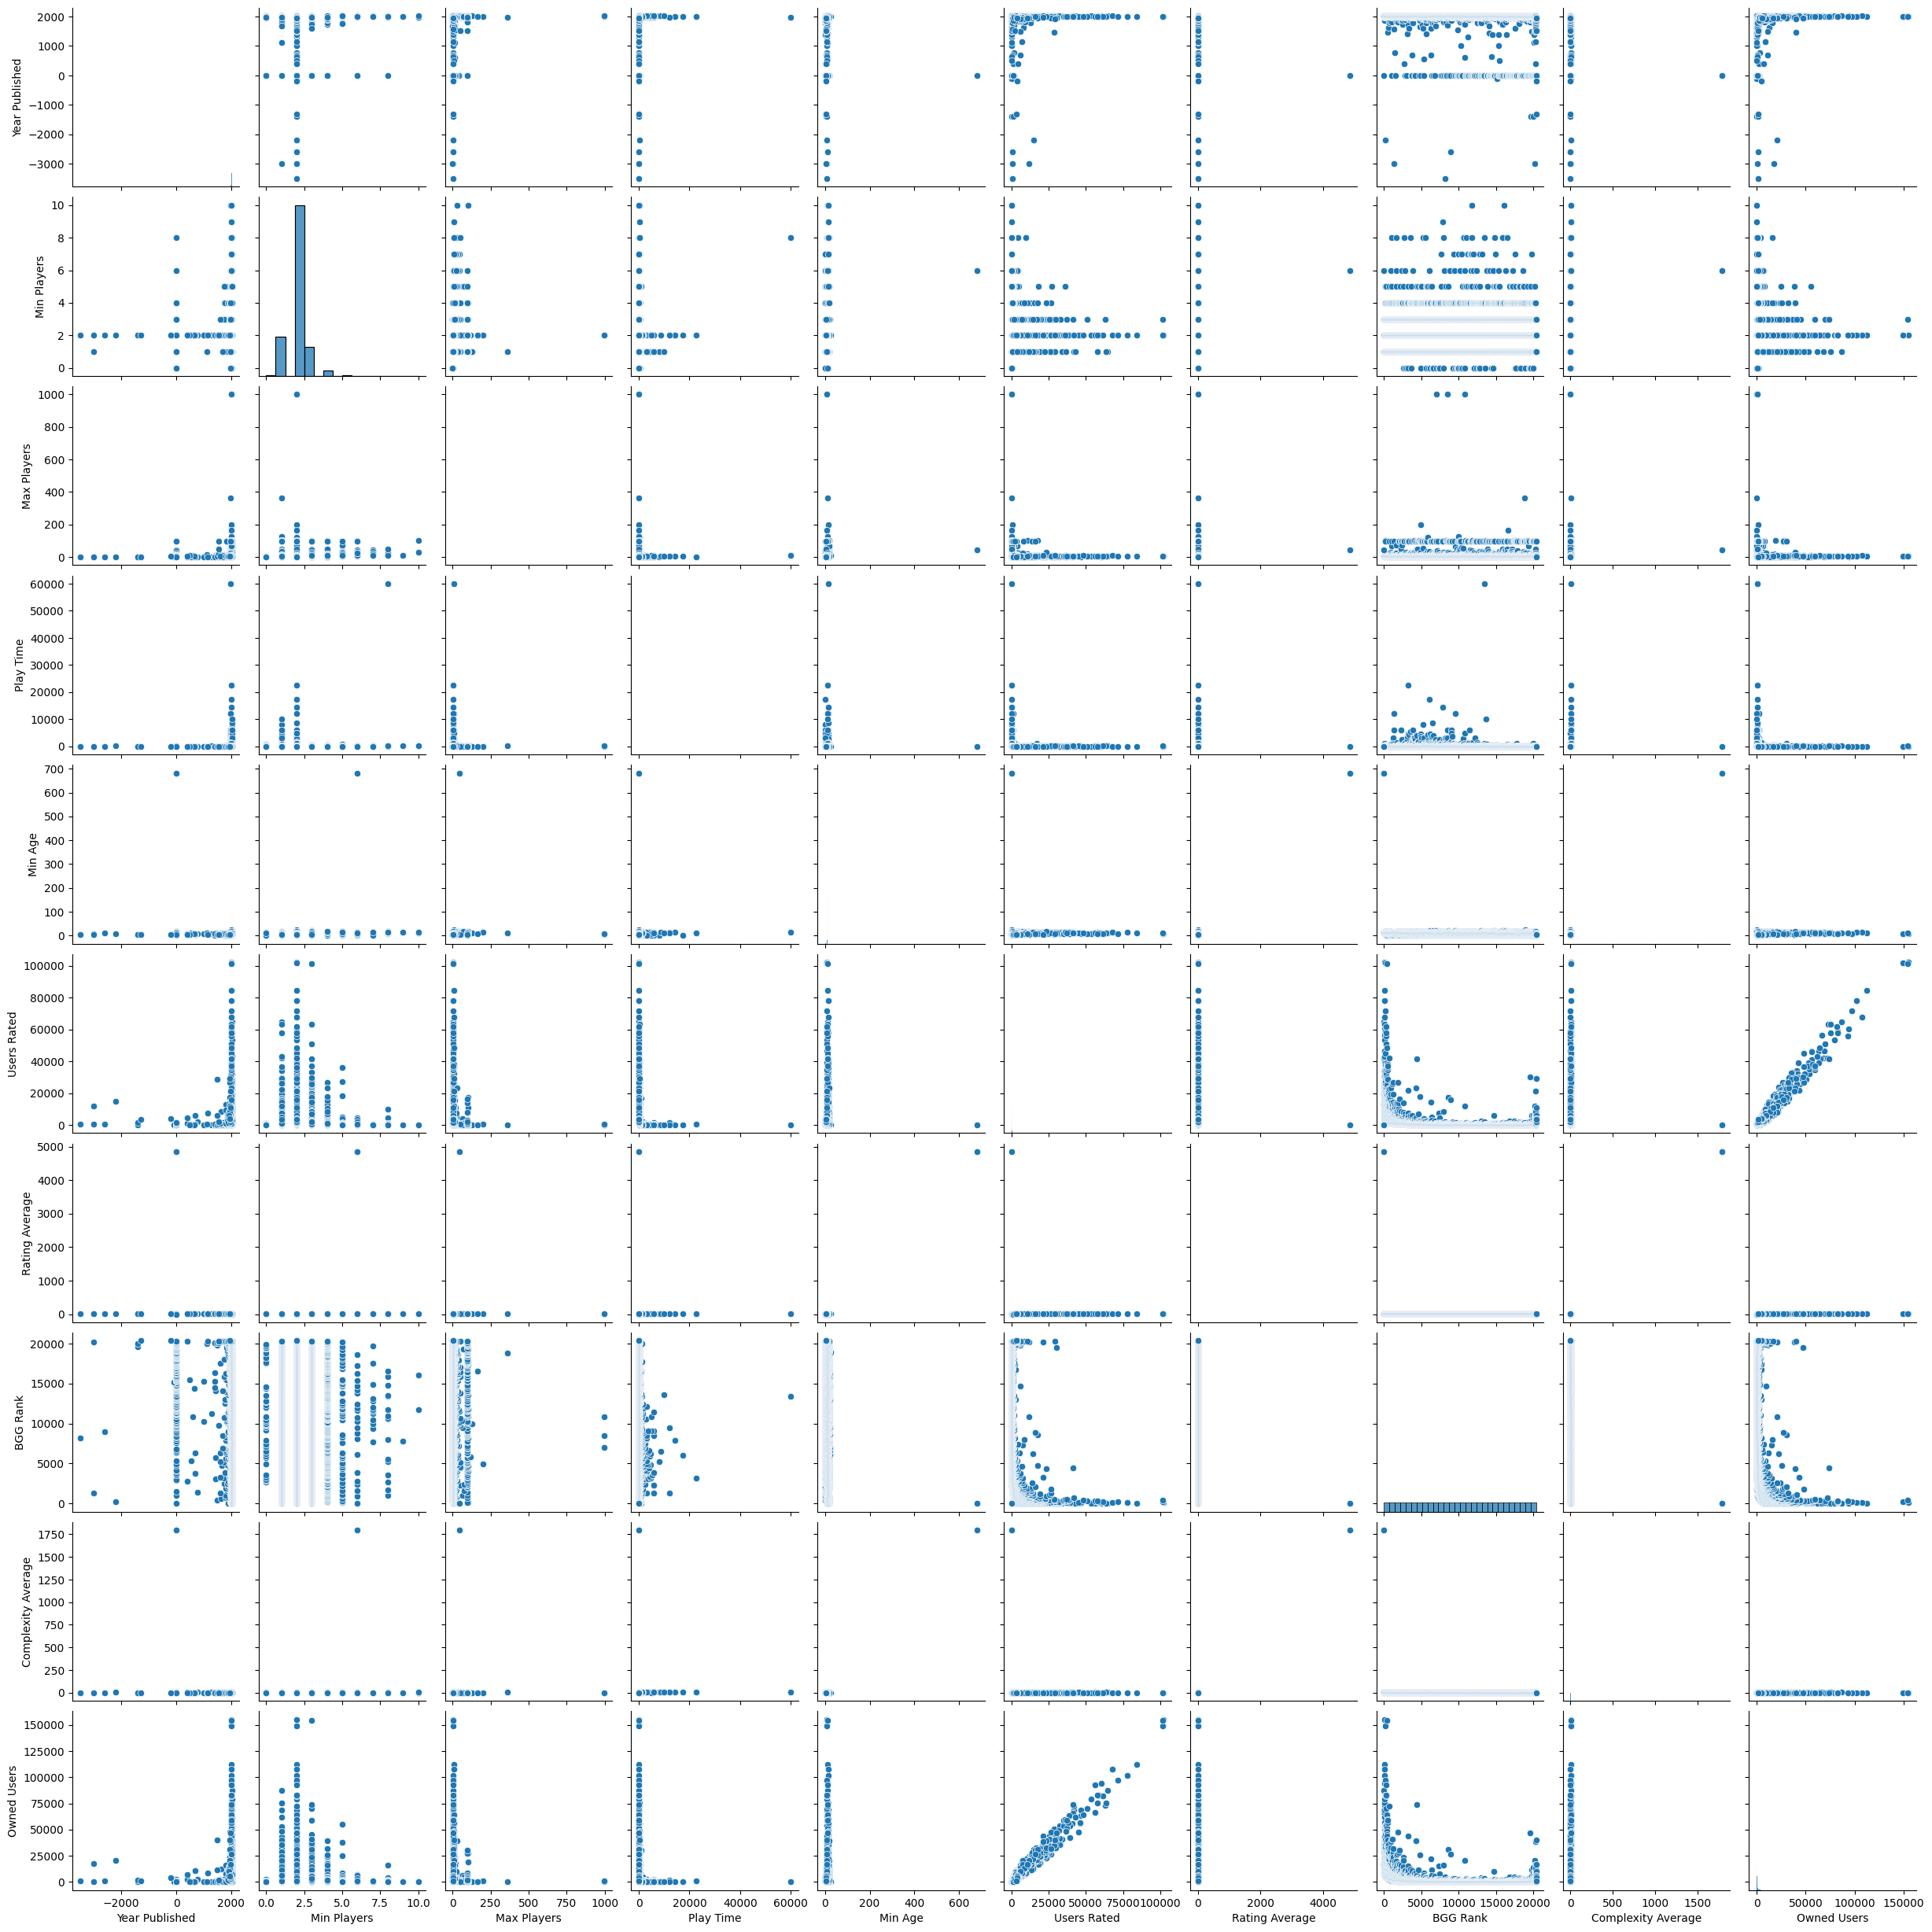

In [108]:
sns.pairplot(df)

<AxesSubplot:>

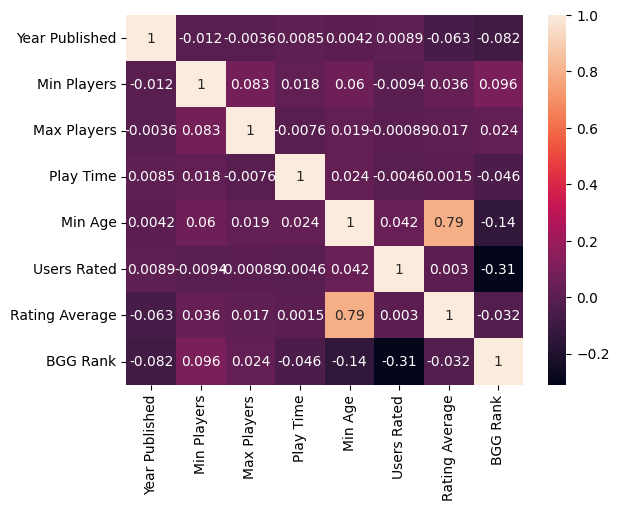

In [37]:
sns.heatmap(df[['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank']].corr(), annot=True)

In [16]:
hist = df[df['Year Published'] > 1600]

hist.head(2)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430,Gloomhaven,2017,1,4,120,14,42055.0,8.79,1.0,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936,Pandemic Legacy: Season 1,2015,2,4,60,13,41643.0,8.61,2.0,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"


In [17]:
AC = df[df['Year Published'] < 1]

AC.head(2)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
172,188,Go,-2200,2,2,180,8,14843.0,7.64,173.0,4.00,20398,"Enclosure, Square Grid",Abstract Games
1043,30618,Eat Poop You Cat,0,3,99,20,0,1589.0,7.45,1044.0,1.11,803,Paper-and-Pencil,Party Games


In [18]:
plt.style.use('bmh')

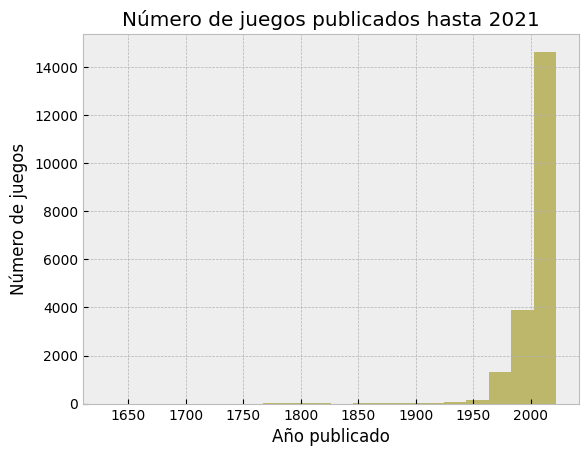

In [19]:
plt.hist(hist['Year Published'], bins=20, color='darkkhaki')
plt.xlabel('Año publicado')
plt.ylabel('Número de juegos')
plt.title('Número de juegos publicados hasta 2021')
plt.show()

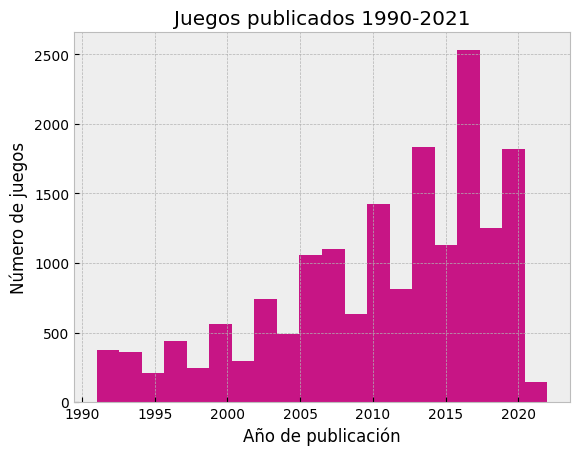

In [27]:
hist2 = df[df['Year Published'] > 1990]


plt.hist(hist2['Year Published'], bins=20, color='mediumvioletred')
plt.xlabel('Año de publicación')
plt.ylabel('Número de juegos')
plt.title('Juegos publicados 1990-2021')
plt.show()

In [28]:
deplot = df[df['Users Rated'] > 100000]

deplot

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
98,30549,Pandemic,2008,2,4,45,8,102214.0,7.61,99.0,2.41,155312,"Action Points, Cooperative Game, Hand Manageme...","Family Games, Strategy Games"
177,822,Carcassonne,2000,2,5,45,7,101853.0,7.42,178.0,1.91,149337,"Area Majority / Influence, Map Addition, Tile ...",Family Games
394,13,Catan,1995,3,4,120,10,101510.0,7.15,395.0,2.32,154531,"Dice Rolling, Hexagon Grid, Income, Modular Bo...","Family Games, Strategy Games"


In [29]:
deplot = df[df['Owned Users'] > 120000]

deplot

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
98,30549,Pandemic,2008,2,4,45,8,102214.0,7.61,99.0,2.41,155312,"Action Points, Cooperative Game, Hand Manageme...","Family Games, Strategy Games"
177,822,Carcassonne,2000,2,5,45,7,101853.0,7.42,178.0,1.91,149337,"Area Majority / Influence, Map Addition, Tile ...",Family Games
394,13,Catan,1995,3,4,120,10,101510.0,7.15,395.0,2.32,154531,"Dice Rolling, Hexagon Grid, Income, Modular Bo...","Family Games, Strategy Games"


In [97]:
df[df['Name'] == "Monopoly"]

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
20336,Monopoly,1933,2,8,180,8,28999.0,4.39,20337.0,1.65,40255,"Auction/Bidding, Income, Loans, Lose a Turn, P...",Family Games


In [90]:
df.describe()

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000,20341.000000
mean,1984.248415,2.019714,5.672386,91.299346,9.601839,841.018681,6.403243,10172.964358,1.991141,1406.915245
std,214.008340,0.690400,15.232103,545.473803,3.644977,3511.730169,0.935955,5872.941141,0.848919,5037.788772
min,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000
25%,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5088.000000,1.330000,146.000000
50%,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10173.000000,1.970000,308.000000
75%,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15259.000000,2.540000,864.000000
max,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000


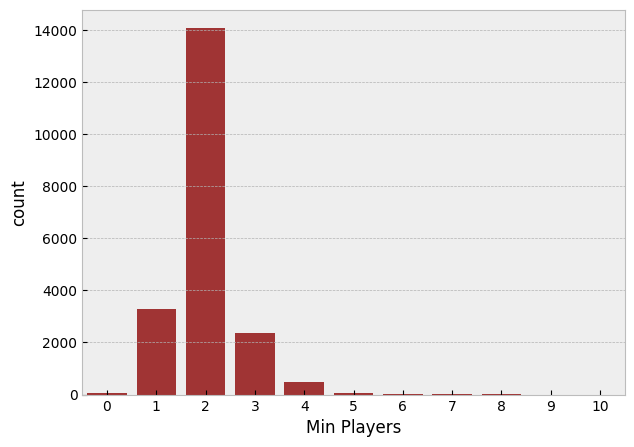

In [75]:
plt.figure(figsize=(7,5))
sns.countplot(x=df["Min Players"], color="firebrick");

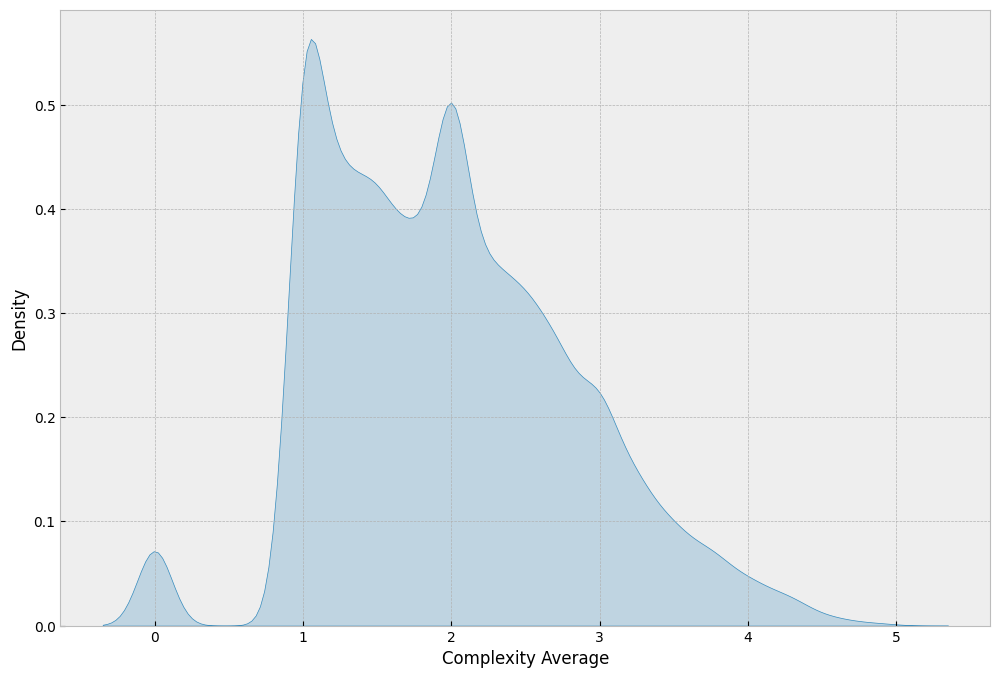

In [60]:
plt.figure(figsize=(12,8))
sns.kdeplot(data=df['Complexity Average'], fill=True);

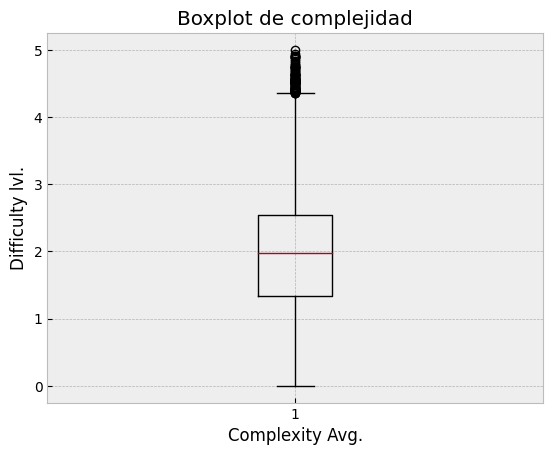

In [372]:
#plt.figure(figsize=(5,7))
plt.boxplot(df['Complexity Average'])

plt.xlabel('Complexity Avg.')
plt.ylabel('Difficulty lvl.')
plt.title('Boxplot de complejidad');

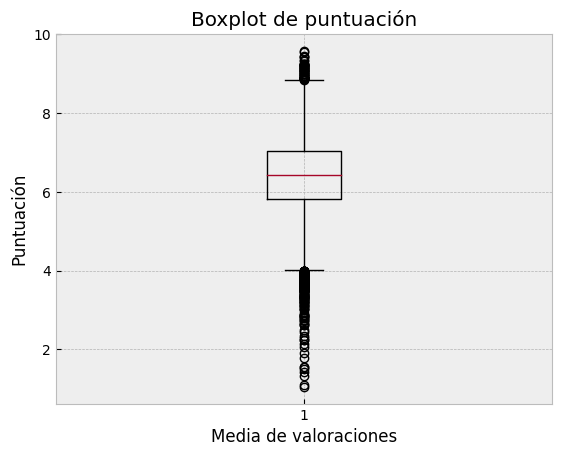

In [31]:
plt.boxplot(df['Rating Average'])

plt.xlabel('Media de valoraciones')
plt.ylabel('Puntuación')
plt.title('Boxplot de puntuación');

In [58]:
df.to_csv('../data/cleancsv/bggcleantomerge.csv', index=False) #creación del archivo csv limpio para merge en bgg2.ipynb

# Mer

In [59]:
mer = pd.read_csv('../data/cleancsv/merged1.csv') #este es el archivo csv mergeado en bgg2 previamente

In [60]:
mer = mer.join(pd.get_dummies(df['Domains'].str.split(', ', expand=True).stack()).groupby(level=0).sum().add_prefix('Domains_'))

In [61]:
mer.shape

(15909, 33)

In [25]:
mer.head(2)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,...,boardgamemechanic_cnt,boardgamefamily_cnt,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Wargames
0,174430,Gloomhaven,2017,1,4,120,14,42055.0,8.79,1.0,...,20.0,12,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,161936,Pandemic Legacy: Season 1,2015,2,4,60,13,41643.0,8.61,2.0,...,8.0,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


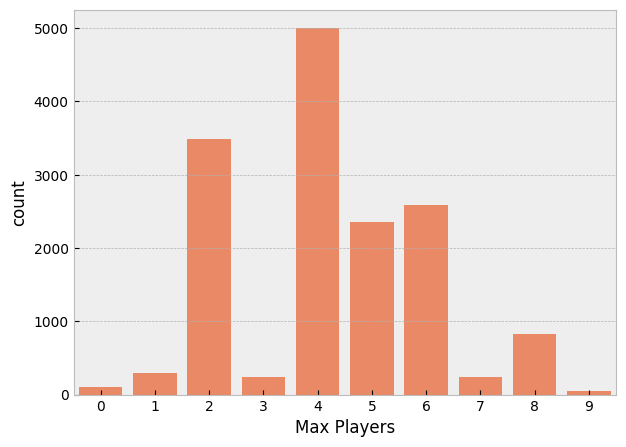

In [26]:
max = mer[mer["Max Players"] < 10]
plt.figure(figsize=(7,5))
sns.countplot(x=max['Max Players'], color="coral");

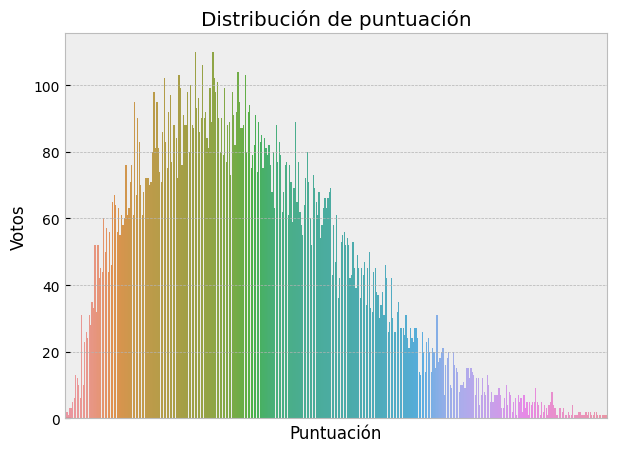

In [27]:
rat = round(mer['Rating Average']) #ejecutar después de cargar mer
plt.figure(figsize=(7,5))
sns.countplot(x=mer['Rating Average'])
plt.xticks([])
plt.xlabel('Puntuación')
plt.ylabel('Votos')
plt.title('Distribución de puntuación');

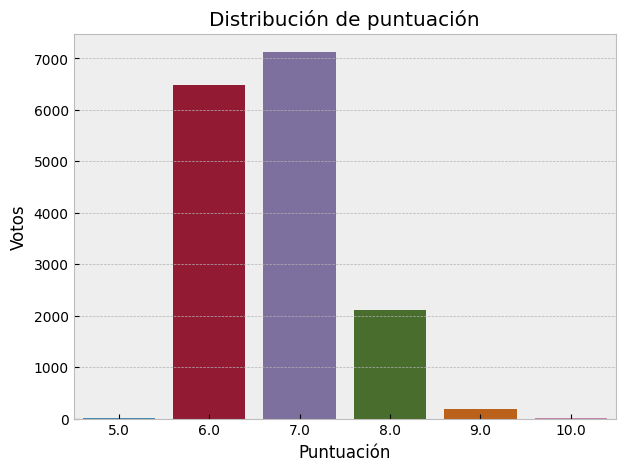

In [28]:
plt.figure(figsize=(7,5))
sns.countplot(x=rat)
plt.xlabel('Puntuación')
plt.ylabel('Votos')
plt.title('Distribución de puntuación');

## Mechanics

In [41]:
mechanics_counts = df['Mechanics'].str.split(', ', expand=True).stack().value_counts().reset_index().rename(columns={'index': 'Mechanics', 0: 'Mechanics_count'})

In [30]:
mechanics_counts

,Mechanics,Mechanics_count
0,Dice Rolling,5672
1,Hand Management,4151
2,Set Collection,2733
3,Variable Player Powers,2534
4,Hexagon Grid,2253
...,...,...
177,Passed Action Token,4
178,Selection Order Bid,3
179,Auction: Dutch Priority,3
180,Auction: Dexterity,3


In [31]:
mc = mechanics_counts.head(18)

In [32]:
uno = mc['Mechanics']
dos = mc['Mechanics_count']

In [33]:
import plotly.express as px

fig = px.bar(mc, x='Mechanics', y='Mechanics_count')
#fig.write_html("mechanics.html")
fig.show()

In [54]:
# merch = mer.merge(mechanics_counts, on='Mechanics', how='outer') #Idea descartada pero se deja aquí por si fuera útil más adelante

In [62]:
mer = mer[mer['Name'] != "Charon Inc."] #more NaNs generados
mer = mer[mer['Name'] != "Central Market"]
mer = mer[mer['Name'] != "Conspiracy"]

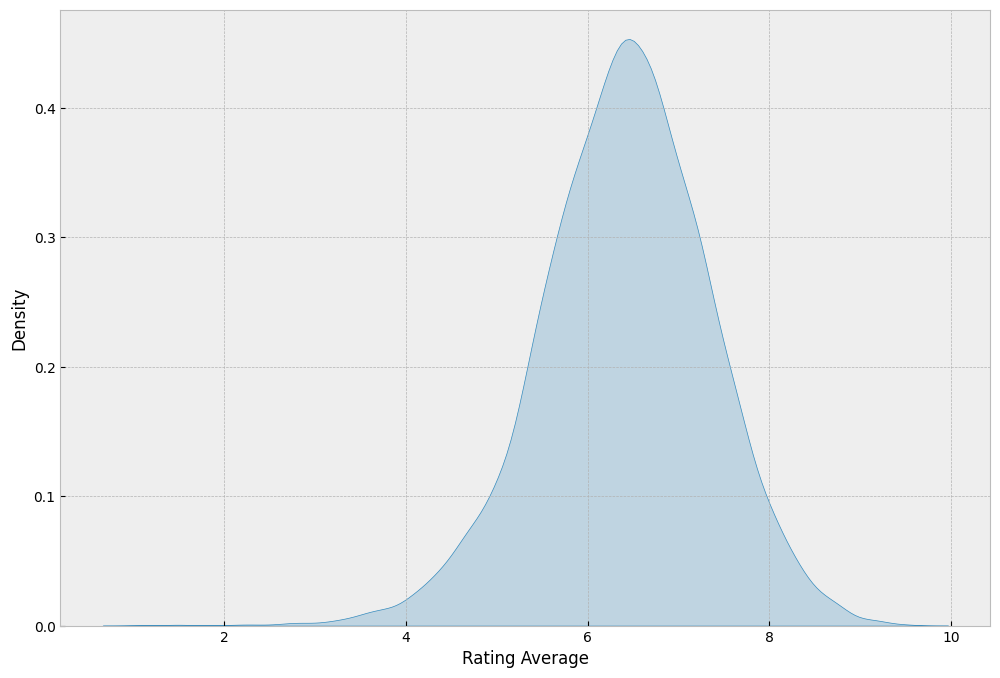

In [48]:
plt.figure(figsize=(12,8))
sns.kdeplot(data=df['Rating Average'], fill=True);

In [64]:
mer = mer.drop(['ID', 'BGG Rank', 'Mechanics', 'Domains'], axis=1) #drop de columnas irrelevantes para ML

In [63]:
data_report(mer)

COL_N,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,...,boardgamefamily_cnt,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Unknown,Domains_Wargames
DATA_TYPE,int64,object,int64,int64,int64,int64,int64,float64,float64,float64,...,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,15851,15633,158,11,48,114,20,2924,368,15851,...,23,2,2,2,2,2,2,2,2,2
CARDIN (%),99.65,98.28,0.99,0.07,0.3,0.72,0.13,18.38,2.31,99.65,...,0.14,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [65]:
mer['target'] = mer['Rating Average'] #para poner la columna a predecir la última
mer = mer.drop(['Rating Average'], axis=1)

<AxesSubplot:>

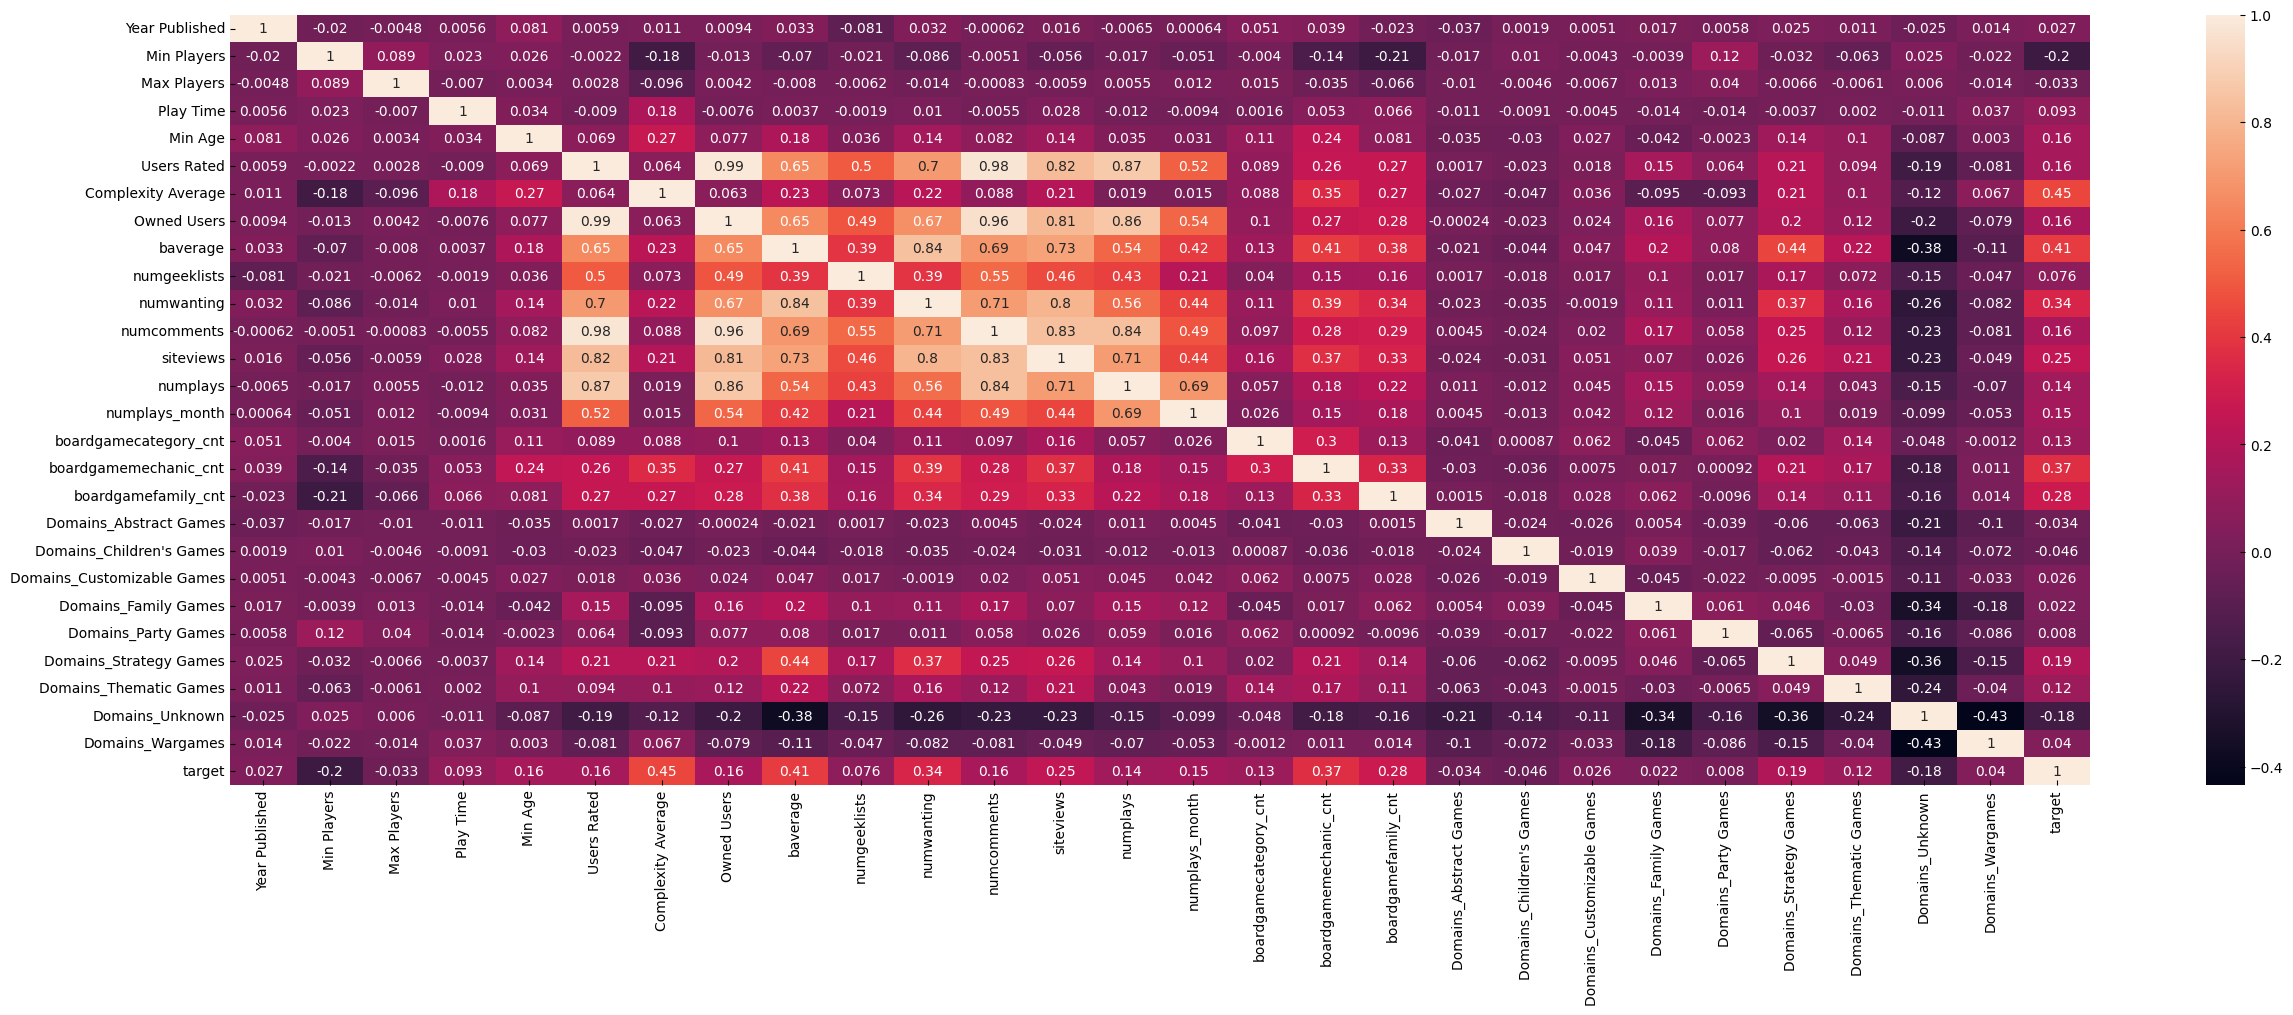

In [66]:
plt.figure(figsize=(30,10))
sns.heatmap(mer.corr(), annot=True)

# Juegos de antes de 1995 y de después

In [ ]:
#Por si quiero hacer una feature selection más adelante
#X = train20[['Complexity Average', 'baverage', 'numwanting', 'siteviews', 'boardgamemechanic_cnt', 'boardgamefamily_cnt',]]

In [67]:
test20 = mer[mer['Year Published'] < 1995] #Un split artificial para tener unos archivos de train y de test
train20 = mer[mer['Year Published'] > 1995]

In [69]:
train20.to_csv('../data/train.csv', index=False) #creación de archivos csv finales
test20.to_csv('../data/test.csv', index=False) 

In [247]:
train20.head(2)

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Complexity Average,Owned Users,baverage,numgeeklists,numwanting,numcomments,siteviews,numplays,numplays_month,boardgamecategory_cnt,boardgamemechanic_cnt,boardgamefamily_cnt,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Unknown,Domains_Wargames,target
0,Gloomhaven,2017,1,4,120,14,42055.0,3.86,68323,8.53724,4649.0,1374.0,8021.0,10583753.0,368134.0,106.0,5.0,20.0,12,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.79
1,Pandemic Legacy: Season 1,2015,2,4,60,13,41643.0,2.84,65294,8.45641,3978.0,850.0,6552.0,3385064.0,238259.0,32.0,2.0,8.0,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,8.61


In [248]:
test20.head(2)

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Complexity Average,Owned Users,baverage,numgeeklists,numwanting,numcomments,siteviews,numplays,numplays_month,boardgamecategory_cnt,boardgamemechanic_cnt,boardgamefamily_cnt,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Unknown,Domains_Wargames,target
64,Crokinole,1876,2,4,30,8,12197.0,1.25,10561,7.65020,3992.0,750.0,2826.0,971306.0,140600.0,27.0,1.0,2.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.91
96,Sherlock Holmes Consulting Detective: The Tham...,1982,1,8,120,13,17236.0,2.68,32905,7.50266,3375.0,845.0,3380.0,1652635.0,32462.0,1.0,5.0,4.0,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.73


# Separación de X e y para entrenar

In [70]:
X = train20.iloc[:,1:-1]
y = train20['target']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10743, 27)
(2686, 27)
(10743,)
(2686,)


## Linear

In [73]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train, y_train)

lmpred = lm.predict(X_test)

print("MAE test:", mean_absolute_error(y_test, lmpred))
print("MAPE test:", mean_absolute_percentage_error(y_test, lmpred))
print("MSE test:", mean_squared_error(y_test, lmpred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, lmpred)))

lm.score(X_train, y_train)

MAE test: 0.3650791585613448
MAPE test: 0.05318163438739856
MSE test: 0.23776622647748702
RMSE test: 0.4876127833409282


0.4997845397461085

In [74]:
intercept = lm.intercept_
features = pd.DataFrame(lm.coef_, X_train.columns, columns=['coefficient'])
features.head().sort_values('coefficient', ascending=False)

,coefficient
Year Published,0.033303
Max Players,0.000325
Play Time,0.000105
Min Age,-0.001327
Min Players,-0.044061


In [75]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scal = std_scale.transform(X_train)

lm_scal = LinearRegression()
lm_scal.fit(X_train_scal, y_train)

intercept_scal = lm_scal.intercept_
features_std = pd.DataFrame(lm_scal.coef_, X_train.columns, columns=['coefficient'])

features_std.sort_values('coefficient', ascending=False).head(5)

,coefficient
numcomments,0.474110
Users Rated,0.363801
baverage,0.312319
Complexity Average,0.278520
Year Published,0.203565


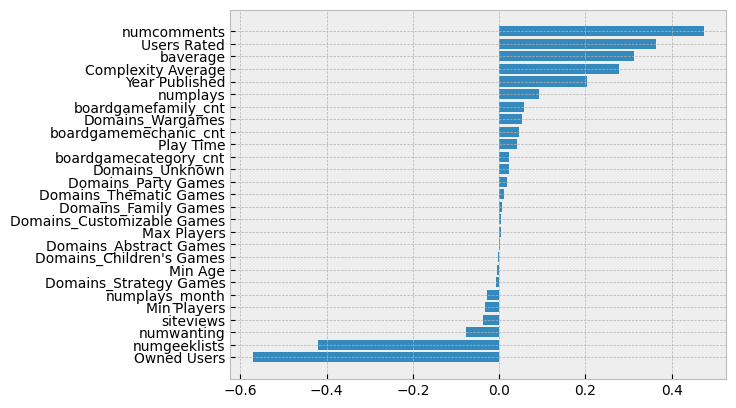

In [76]:
features_std = features_std.sort_values('coefficient', ascending=True)
plt.barh(features_std.index, features_std.coefficient);

## Poly, cuidado que con más de 4 tarda mucho

In [77]:
from sklearn.preprocessing import PolynomialFeatures
poly_feats = PolynomialFeatures(degree = 3)
poly_feats.fit(X)
X_poly = poly_feats.transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

pol_reg.score(X_poly,y)

0.7108706952089376

## XGB

In [78]:
import xgboost

In [79]:
xgb_reg = xgboost.XGBRegressor(random_state=17) #con test

xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

print("MAE test:", mean_absolute_error(y_test, y_pred))
print("MAPE test:", mean_absolute_percentage_error(y_test, y_pred))
print("MSE test:", mean_squared_error(y_test, y_pred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_pred)))

xgb_reg.score(X_test, y_test)

MAE test: 0.14924523489207184
MAPE test: 0.021294985497804023
MSE test: 0.05304875494112691
RMSE test: 0.23032315328930114


0.8868909762131533

In [80]:
importance = xgb_reg.get_booster().get_score(importance_type="weight")

In [81]:
xgbweight = pd.DataFrame.from_dict(importance, orient="index", columns=["Importance"])

fig = px.pie(xgbweight, values="Importance", names=xgbweight.index, title="Importance of Features")

fig.show()

## GBR, candidato 1

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
gbrt = GradientBoostingRegressor(max_depth=8,
                                 n_estimators=4,
                                 learning_rate=1.0,
                                 random_state=17)
gbrt.fit(X_train, y_train)


y_pred_gbrt = gbrt.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, y_pred_gbrt))
print("MAPE test:", mean_absolute_percentage_error(y_test, y_pred_gbrt))
print("MSE test:", mean_squared_error(y_test, y_pred_gbrt))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_pred_gbrt)))
gbrt.score(X_test, y_test)

MAE test: 0.2263299945736056
MAPE test: 0.03213844858227853
MSE test: 0.12480941384324834
RMSE test: 0.3532837582500055


0.7338849710066637

## ADA Boost

In [84]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=200,
                            random_state=17)
ada_reg.fit(X_train, y_train)

y_pred_ada_reg = ada_reg.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, y_pred_ada_reg))
print("MAPE test:", mean_absolute_percentage_error(y_test, y_pred_ada_reg))
print("MSE test:", mean_squared_error(y_test, y_pred_ada_reg))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_pred_ada_reg)))
ada_reg.score(X_test, y_test)

MAE test: 0.46026227953910215
MAPE test: 0.07022596405952593
MSE test: 0.2834649150737707
RMSE test: 0.5324142325988015


0.39560429161064625

## KNN

In [85]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)

knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, prediction))
print("MAPE test:", mean_absolute_percentage_error(y_test, prediction))
print("MSE test:", mean_squared_error(y_test, prediction))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, prediction)))
print(knn.score(X_train, y_train))

MAE test: 0.5442963514519732
MAPE test: 0.07956934346779794
MSE test: 0.4969020662695458
RMSE test: 0.7049128075652661
0.6614685058959885


## DecisionTree, candidato 2

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=9)

tree.fit(X_train, y_train)
predtree = tree.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, predtree))
print("MAPE test:", mean_absolute_percentage_error(y_test, predtree))
print("MSE test:", mean_squared_error(y_test, predtree))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predtree)))
tree.score(X_test, y_test)

MAE test: 0.26392738835030904
MAPE test: 0.03763857380639277
MSE test: 0.15334616709725737
RMSE test: 0.3915943910441739


0.6730397295643484

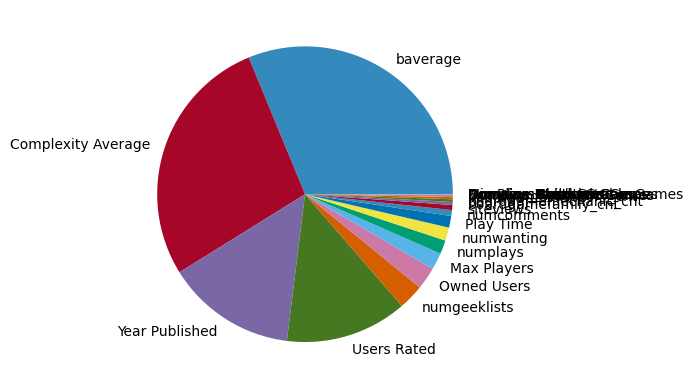

[(0.3121974858423187, 'baverage'),
 (0.27633615238163967, 'Complexity Average'),
 (0.14186757777855036, 'Year Published'),
 (0.13331132871933932, 'Users Rated'),
 (0.02770537634349698, 'numgeeklists'),
 (0.02445736362275299, 'Owned Users'),
 (0.018331068471345854, 'Max Players'),
 (0.015009638352138154, 'numplays'),
 (0.014478286212101019, 'numwanting'),
 (0.012701122910156768, 'Play Time'),
 (0.006425443305219068, 'numcomments'),
 (0.005469099295975181, 'siteviews'),
 (0.003320434982776945, 'boardgamefamily_cnt'),
 (0.0028852903770827144, 'boardgamemechanic_cnt'),
 (0.002354876826375856, 'Min Age'),
 (0.00227604318963255, 'boardgamecategory_cnt'),
 (0.0003277916202387898, 'Domains_Thematic Games'),
 (0.0002682808954336887, 'Domains_Wargames'),
 (0.00018769441107433716, 'Min Players'),
 (6.177495466690026e-05, 'Domains_Unknown'),
 (2.348704941686421e-05, "Domains_Children's Games"),
 (4.3824582672988725e-06, 'Domains_Family Games'),
 (0.0, 'numplays_month'),
 (0.0, 'Domains_Strategy Ga

In [87]:
importances = tree.feature_importances_ #intento 1 de pie plot, se juntaban las columnas y probé a hacerlo con plotly
feature_names=X.columns
rf_feature_importance=sorted(zip(importances, feature_names), reverse=True)
fig1 = plt.figure()
#add subplots
ax = fig1.add_subplot(111)
ax.pie([a[0] for a in rf_feature_importance],labels=[a[1] for a in rf_feature_importance],normalize=True)
plt.show()
rf_feature_importance

## Bayes Ridge

In [88]:
from sklearn.linear_model import BayesianRidge

bayes = BayesianRidge()

bayes.fit(X_train, y_train)

bayespred = bayes.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, bayespred))
print("MAPE test:", mean_absolute_percentage_error(y_test, bayespred))
print("MSE test:", mean_squared_error(y_test, bayespred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, bayespred)))
bayes.score(X_test, y_test)

MAE test: 0.36519364586013847
MAPE test: 0.053207008671425436
MSE test: 0.23794005383388891
RMSE test: 0.4877909940065406


0.49267108645982427

## Random Forest, candidato 3

In [89]:
rf = RandomForestRegressor(max_features=7, max_depth=9, random_state=17)

rf.fit(X_train, y_train)
rfp = rf.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, rfp))
print("MAPE test:", mean_absolute_percentage_error(y_test, rfp))
print("MSE test:", mean_squared_error(y_test, rfp))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, rfp)))
rf.score(X_test, y_test)

MAE test: 0.2366624172029157
MAPE test: 0.034002401406643394
MSE test: 0.1094939094595601
RMSE test: 0.3308986392531104


0.7665402473004177

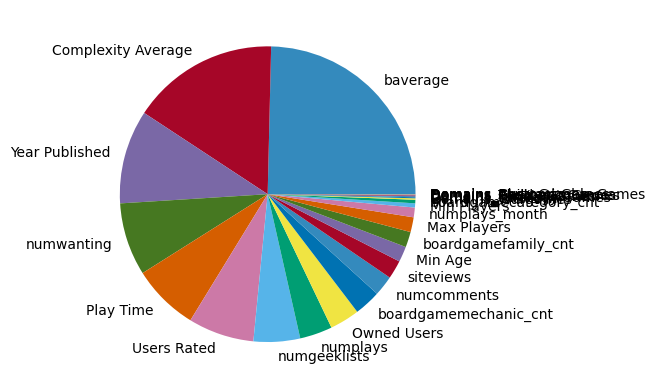

[(0.24623947881408428, 'baverage'),
 (0.16115248447273414, 'Complexity Average'),
 (0.10253594194857406, 'Year Published'),
 (0.07964088697176333, 'numwanting'),
 (0.07294005320996938, 'Play Time'),
 (0.07205372390162662, 'Users Rated'),
 (0.05083717999402258, 'numgeeklists'),
 (0.03560747094111863, 'numplays'),
 (0.032591119732231784, 'Owned Users'),
 (0.028854774571142737, 'boardgamemechanic_cnt'),
 (0.022214382436555286, 'numcomments'),
 (0.020217196047217327, 'siteviews'),
 (0.016976118485819706, 'Min Age'),
 (0.016896145813925314, 'boardgamefamily_cnt'),
 (0.016187474563040614, 'Max Players'),
 (0.0106390451982199, 'numplays_month'),
 (0.004548834340796633, 'Min Players'),
 (0.003867758032518336, 'boardgamecategory_cnt'),
 (0.0015589148668728884, 'Domains_Wargames'),
 (0.001135164943256965, 'Domains_Unknown'),
 (0.0011208826312313906, 'Domains_Strategy Games'),
 (0.0008229962524669087, 'Domains_Family Games'),
 (0.0004570553658901779, 'Domains_Thematic Games'),
 (0.000274382598255

In [90]:
importances = rf.feature_importances_
feature_names=X.columns
rf_feature_importance=sorted(zip(importances, feature_names), reverse=True)
fig1 = plt.figure()
#add subplots
ax = fig1.add_subplot(111)
ax.pie([a[0] for a in rf_feature_importance],labels=[a[1] for a in rf_feature_importance],normalize=True)
plt.show()
rf_feature_importance

In [91]:
importances = rf.feature_importances_
feature_names = X.columns
rf_feature_importance = sorted(zip(importances, feature_names), reverse=True)

importance_threshold = sum(importances) * 0.001
rf_feature_importance = [x for x in rf_feature_importance if x[0] >= importance_threshold]

In [92]:
fig = go.Figure(data=[go.Pie(labels=[a[1] for a in rf_feature_importance], values=[a[0] for a in rf_feature_importance])])
fig.show()
#fig.write_html("feature.html")

# Prueba con datos nuevos

In [93]:
tester2 = test20.iloc[:,1:-1]
target = test20['target']

In [94]:
xgbT = xgb_reg.predict(tester2)

print("MAE test:", mean_absolute_error(test20["target"], xgbT))
print("MAPE test:", mean_absolute_percentage_error(test20["target"], xgbT))
print("MSE test:", mean_squared_error(test20["target"], xgbT))
print("RMSE test:", np.sqrt(mean_squared_error(test20["target"], xgbT)))
xgb_reg.score(tester2, target)

MAE test: 0.13525308683469847
MAPE test: 0.02043624034074696
MSE test: 0.041687553587219185
RMSE test: 0.2041753011194527


0.857178530329807

In [95]:
gbrT = gbrt.predict(tester2)

print("MAE test:", mean_absolute_error(test20["target"], gbrT))
print("MAPE test:", mean_absolute_percentage_error(test20["target"], gbrT))
print("MSE test:", mean_squared_error(test20["target"], gbrT))
print("RMSE test:", np.sqrt(mean_squared_error(test20["target"], gbrT)))
gbrt.score(tester2, target)

MAE test: 0.21088251537436567
MAPE test: 0.03184916760264128
MSE test: 0.11143223361200605
RMSE test: 0.33381466955783423


0.6182334053304034

In [96]:
treeT = tree.predict(tester2)

print("MAE test:", mean_absolute_error(test20["target"], treeT))
print("MAPE test:", mean_absolute_percentage_error(test20["target"], treeT))
print("MSE test:", mean_squared_error(test20["target"], treeT))
print("RMSE test:", np.sqrt(mean_squared_error(test20["target"], treeT)))
tree.score(tester2, target)

MAE test: 0.26806153684212797
MAPE test: 0.04078299285594399
MSE test: 0.17769407484007588
RMSE test: 0.42153775019572787


0.3912204786196516

In [97]:
rfT = rf.predict(tester2)

print("MAE test:", mean_absolute_error(test20["target"], rfT))
print("MAPE test:", mean_absolute_percentage_error(test20["target"], rfT))
print("MSE test:", mean_squared_error(test20["target"], rfT))
print("RMSE test:", np.sqrt(mean_squared_error(test20["target"], rfT)))
rf.score(tester2, target)

MAE test: 0.266647662226307
MAPE test: 0.04111951836778231
MSE test: 0.1199725063492866
RMSE test: 0.3463704755738956


0.5889744491488959

### Ordenación de scores

In [98]:
results_df = pd.DataFrame(columns=['Model', 'Score'])

score = gbrt.score(tester2, target)
results_df = results_df.append({'Model': 'Gradient Boosting Regressor', 'Score': score}, ignore_index=True)

score1 = tree.score(tester2, target)
results_df = results_df.append({'Model': 'Decision Tree', 'Score': score1}, ignore_index=True)

score2 = rf.score(tester2, target)
results_df = results_df.append({'Model': 'Random Forest', 'Score': score2}, ignore_index=True)

score3 = lm.score(tester2, target)
results_df = results_df.append({'Model': 'Linear', 'Score': score3}, ignore_index=True)

#score4 = pol_reg.score(tester2, target)
#results_df = results_df.append({'Model': 'Polynomial', 'Score': score4}, ignore_index=True)

score5 = xgb_reg.score(tester2, target)
results_df = results_df.append({'Model': 'XGB', 'Score': score5}, ignore_index=True)

score6 = ada_reg.score(tester2, target)
results_df = results_df.append({'Model': 'AdaBoost', 'Score': score6}, ignore_index=True)

score7 = knn.score(tester2, target)
results_df = results_df.append({'Model': 'KNN', 'Score': score7}, ignore_index=True)

score8 = bayes.score(tester2, target)
results_df = results_df.append({'Model': 'BayesRidge', 'Score': score8}, ignore_index=True)


results_df.sort_values(by='Score', ascending=False)

,Model,Score
4,XGB,0.857179
0,Gradient Boosting Regressor,0.618233
2,Random Forest,0.588974
1,Decision Tree,0.391220
5,AdaBoost,-0.186831
6,KNN,-0.972401
3,Linear,-886.350091
7,BayesRidge,-888.506879


In [99]:
linechart = results_df.sort_values(by='Score').tail(4)

In [100]:
linechart

,Model,Score
1,Decision Tree,0.391220
2,Random Forest,0.588974
0,Gradient Boosting Regressor,0.618233
4,XGB,0.857179


In [101]:
fig = px.funnel(linechart, x='Model', y="Score", title="Score of Different Models")

fig.show()

# Pipeline

### XGB

In [102]:
xpipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('classifier', xgboost.XGBRegressor())])
xgbp = {
    'classifier': [xgboost.XGBRegressor(random_state=17)],
    'classifier__n_estimators': [100, 500],
    'classifier__max_depth': [4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.5],
}

clf = GridSearchCV(estimator = xpipe,
                  param_grid = xgbp,
                  scoring='r2',
                  verbose=3,
                  cv = 5)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END classifier=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=17,
             reg_alpha=None, reg_lambda=None, ...), classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100;, score=0.869 total time=   1.0s
[CV 2/5] END classifier=XGBRegressor(base_score=None, booster=None,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer()),
                                       ('classifier',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     gamma=None, gpu_id=None,
                                             

In [103]:
print(clf.best_estimator_)
print(" ")
print(clf.best_score_)
print(" ")
print(clf.best_params_)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=17, reg_alpha=0,


In [104]:
predict = clf.best_estimator_.predict(X_test)
clf.best_estimator_.score(X_test,y_test)

0.8992730973916255

### XGB final

In [105]:
xgb_final = xgboost.XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 500, random_state=17) #con test

xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict(X_test)

print("MAE test:", mean_absolute_error(y_test, y_pred))
print("MAPE test:", mean_absolute_percentage_error(y_test, y_pred))
print("MSE test:", mean_squared_error(y_test, y_pred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_pred)))

xgb_final.score(X_test, y_test)

MAE test: 0.13344806259280254
MAPE test: 0.018996213898278266
MSE test: 0.04724662568181239
RMSE test: 0.21736288938503828


0.8992621087144625

In [106]:

importance = xgb_final.get_booster().get_score(importance_type="weight")
xgbweight = pd.DataFrame.from_dict(importance, orient="index", columns=["Importance"])

fig = px.pie(xgbweight, values="Importance", names=xgbweight.index, title="Importance of Features")
#fig.write_html("final.html")
fig.show()

In [107]:
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
clf.best_estimator_.score(tester2, target)

MAE test: 0.13339552422734402
MAPE test: 0.018988539802219238
MSE test: 0.04724147193171862
RMSE test: 0.21735103388693283


0.8895227390963318

### Pipeline con GBR

In [108]:
gpipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('classifier', GradientBoostingRegressor())])
gradient = {
    'classifier': [GradientBoostingRegressor(random_state=17)],
    'classifier__n_estimators': [9, 10],
    'classifier__max_depth': [4, 5, 6],
    'classifier__learning_rate': [0.5, 1.0],
    'classifier__max_features': ['auto', 'sqrt'],
}

clf = GridSearchCV(estimator = gpipe,
                  param_grid = gradient,
                  scoring='r2',
                  verbose=3,
                  cv = 5)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier=GradientBoostingRegressor(random_state=17), classifier__learning_rate=0.5, classifier__max_depth=4, classifier__max_features=auto, classifier__n_estimators=9; total time=   0.3s
[CV] END classifier=GradientBoostingRegressor(random_state=17), classifier__learning_rate=0.5, classifier__max_depth=4, classifier__max_features=auto, classifier__n_estimators=9; total time=   0.2s
[CV] END classifier=GradientBoostingRegressor(random_state=17), classifier__learning_rate=0.5, classifier__max_depth=4, classifier__max_features=auto, classifier__n_estimators=9; total time=   0.2s
[CV] END classifier=GradientBoostingRegressor(random_state=17), classifier__learning_rate=0.5, classifier__max_depth=4, classifier__max_features=auto, classifier__n_estimators=9; total time=   0.2s
[CV] END classifier=GradientBoostingRegressor(random_state=17), classifier__learning_rate=0.5, classifier__max_depth=4, classifier__max_features=a

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer()),
                                       ('classifier',
                                        GradientBoostingRegressor())]),
             param_grid={'classifier': [GradientBoostingRegressor(learning_rate=0.5,
                                                                  max_depth=6,
                                                                  max_features='auto',
                                                                  n_estimators=10,
                                                                  random_state=17)],
                         'classifier__learning_rate': [0.5, 1.0],
                         'classifier__max_depth': [4, 5, 6],
                         'classifier__max_features': ['auto', 'sqrt'],
                         'classifier__n_estimators': [9, 10]},
             scoring='r2', verbose=2)

In [109]:
predict = clf.best_estimator_.predict(X_test)

In [110]:
clf.best_estimator_.score(X_test,y_test)

0.8261741655832233

In [111]:
print(clf.best_estimator_)
print(" ")
print(clf.best_score_)
print(" ")
print(clf.best_params_)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           max_features='auto', n_estimators=10,
                                           random_state=17))])
 
0.8372958874795025
 
{'classifier': GradientBoostingRegressor(learning_rate=0.5, max_depth=6, max_features='auto',
                          n_estimators=10, random_state=17), 'classifier__learning_rate': 0.5, 'classifier__max_depth': 6, 'classifier__max_features': 'auto', 'classifier__n_estimators': 10}


In [112]:
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
clf.best_estimator_.score(tester2, target)

MAE test: 0.1917483621520819
MAPE test: 0.027343961334864476
MSE test: 0.08152527343697942
RMSE test: 0.2855263095355302


0.7925218708705162

In [114]:
with open('../model/modelgbr', 'wb') as archivo_salida:
    pickle.dump(clf, archivo_salida)

In [115]:
with open('../model/modelgbr', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [116]:
predict = loaded_model.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
loaded_model.score(tester2, target)

MAE test: 0.1917483621520819
MAPE test: 0.027343961334864476
MSE test: 0.08152527343697942
RMSE test: 0.2855263095355302


0.7925218708705162

### Pipeline con RF

In [117]:
fpipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('classifier', RandomForestRegressor())])
random = {
    'classifier': [RandomForestRegressor(random_state=17)],
    'classifier__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'classifier__max_features': [1, 2, 3, 4, 5, 6],
}

clf = GridSearchCV(estimator = fpipe,
                  param_grid = random,
                  scoring='r2',
                  verbose=3,
                  cv = 10)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.347 total time=   0.4s
[CV 2/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.345 total time=   0.3s
[CV 3/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.387 total time=   0.3s
[CV 4/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.353 total time=   0.2s
[CV 5/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.338 total time=   0.3s
[CV 6/10] END classifier=RandomForestRegressor(random_state=17), classifier__max_depth=5, classifier__max_features=1;, score=0.364 total time=   0.2s
[CV 7/10] END classifier=RandomForest

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer()),
                                       ('classifier',
                                        RandomForestRegressor())]),
             param_grid={'classifier': [RandomForestRegressor(max_depth=12,
                                                              max_features=6,
                                                              random_state=17)],
                         'classifier__max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'classifier__max_features': [1, 2, 3, 4, 5, 6]},
             scoring='r2', verbose=3)

In [118]:
print(clf.best_estimator_)
print(" ")
print(clf.best_score_)
print(" ")
print(clf.best_params_)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 RandomForestRegressor(max_depth=12, max_features=6,
                                       random_state=17))])
 
0.8026383219690943
 
{'classifier': RandomForestRegressor(max_depth=12, max_features=6, random_state=17), 'classifier__max_depth': 12, 'classifier__max_features': 6}


In [119]:
predict = clf.best_estimator_.predict(X_test)
clf.best_estimator_.score(X_test,y_test)

0.8002269877014737

In [ ]:
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
clf.best_estimator_.score(tester2, target)

In [121]:
with open('../model/modelrf', 'wb') as archivo_salida: #asegurarse de ejecutar el pipeline antes ya que los pipelines tienen una variable con el mismo nombre
    pickle.dump(clf, archivo_salida)

In [122]:
with open('../model/modelrf', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [123]:
predict = loaded_model.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
loaded_model.score(tester2, target)

MAE test: 0.2162367307372419
MAPE test: 0.031013793773100345
MSE test: 0.09369464273024379
RMSE test: 0.3060958064564815


0.6473753821370065

# Final Pickle

In [124]:
pipe_final = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer()),
    ('classifier', xgboost.XGBRegressor(random_state=17, learning_rate = 0.1, max_depth = 5, n_estimators = 500))])

pipe_final
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('classifier',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=17, reg_alpha=0,


In [125]:
with open('../model/production/modelfinal', 'wb') as archivo_salida:
    pickle.dump(pipe_final, archivo_salida)

In [126]:
with open('../model/production/modelfinal', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [127]:
predict = loaded_model.predict(X_test)
print("MAE test:", mean_absolute_error(y_test, predict))
print("MAPE test:", mean_absolute_percentage_error(y_test, predict))
print("MSE test:", mean_squared_error(y_test, predict))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, predict)))
loaded_model.score(tester2, target)

MAE test: 0.13339552422734402
MAPE test: 0.018988539802219238
MSE test: 0.04724147193171862
RMSE test: 0.21735103388693283


0.8895227390963318

In [128]:
FinalTest = tester2
respuestas = target

In [129]:
FinalTest.to_csv('../data/Test_datos_nuevos.csv', index=False) 
respuestas.to_csv('../data/respuestas.csv', index=False)

## Test de modelo final

In [130]:
predictfinal = loaded_model.predict(FinalTest)

In [131]:
print("MAE test:", mean_absolute_error(respuestas, predictfinal))
print("MAPE test:", mean_absolute_percentage_error(respuestas, predictfinal))
print("MSE test:", mean_squared_error(respuestas, predictfinal))
print("RMSE test:", np.sqrt(mean_squared_error(respuestas, predictfinal)))

loaded_model.score(FinalTest, respuestas)

MAE test: 0.11423326619138846
MAPE test: 0.01726936200248045
MSE test: 0.03224673954641456
RMSE test: 0.17957377187778442


0.8895227390963318